# Matemática da Arquitetura Transformer na Análise e Forecast de Séries Temporais

https://arxiv.org/abs/1706.03762

HuggingFace como fonte de dados e do modelo pré-treinado.

https://huggingface.co/

## Instalar e carregar pacotes

In [14]:
!pip install -q transformers==4.37.2

In [4]:
!pip install -q datasets==2.16.1

In [5]:
!pip install -q evaluate==0.4.1

In [6]:
!pip install -q accelerate==0.26.1

In [7]:
!pip install -q -U gluonts==0.16.2

https://ts.gluon.ai

In [8]:
!pip install -q ujson==5.4.0

In [9]:
!pip install -q urllib3==1.26.16

In [10]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [11]:
# Ajusta problema de performance do TensorFlow em CPUs Intel
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [12]:
# Ajusta problema de performance do PyTorch 
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [15]:
# Imports
import ujson
import urllib3
import evaluate
import torch
import transformers
import accelerate
import gluonts
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import lru_cache
from functools import partial
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from transformers import PretrainedConfig
from typing import Optional
from accelerate import Accelerator
from torch.optim import AdamW
from evaluate import load
from typing import Iterable
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches
from gluonts.time_feature import get_seasonality
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.transform.sampler import InstanceSampler
from gluonts.time_feature import (time_features_from_frequency_str, TimeFeature, get_lags_for_frequency)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
import warnings
warnings.filterwarnings('ignore')

## Dados
https://huggingface.co/datasets/Monash-University/monash_tsf

In [19]:
dataset = load_dataset("monash_tsf", "tourism_monthly")
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [22]:
dataset['train']

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

In [24]:
exemplo_treino = dataset['train'][0]
type(exemplo_treino)

dict

In [25]:
exemplo_treino.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [31]:
print(exemplo_treino['start'])
print(exemplo_treino['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [33]:
exemplo_valid = dataset['validation'][0]
exemplo_valid.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [34]:
print(exemplo_valid['start'])
print(exemplo_valid['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [36]:
# Vamos extrair um elemento de teste
exemplo_teste = dataset['test'][0]

In [38]:
print(exemplo_teste['start'])
print(exemplo_teste['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [39]:
len(exemplo_treino['target'])

139

In [40]:
len(exemplo_valid['target'])

163

In [41]:
len(exemplo_teste['target'])

187

## Visualização da série temporal

In [43]:
# Frequência da série temporal (1 mês)
freq = "1M"

# Janela de previsão (24 meses)
prediction_length = 24

In [46]:
# Verifica se o comprimento dos dados de validação permite a janela de previsão
assert len(exemplo_treino["target"]) + prediction_length == len(exemplo_valid["target"])

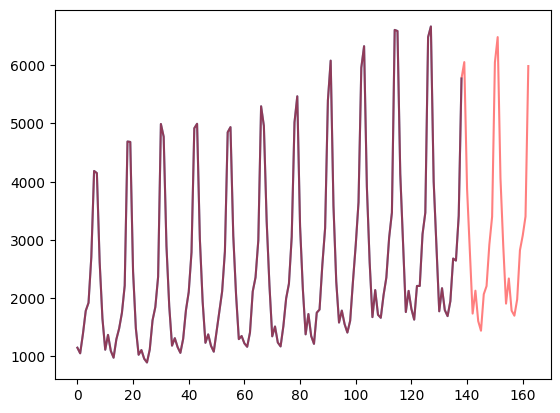

In [49]:
# Plot
fig, ax = plt.subplots()
ax.plot(exemplo_treino['target'], label='Treino')
ax.plot(exemplo_valid["target"], color = "red", alpha = 0.5)
plt.show()

## Converter o formato de dados

In [50]:
dataset_treino = dataset['train']
dataset_teste = dataset['test'] 

In [51]:
# Função para converter datas para períodos de datas
def convert_to_period(date, freq: str):
    return pd.Period(date, freq)

In [ ]:
# Função para definir o início do batch de dados
def define_start(batch, freq):
    batch["start"] = [convert_to_period(date, freq) for date in batch["start"]]
    return batch

In [ ]:
# Ajusta os datasets das séries temporais no formato apropriado
dataset_treino.set_transform(partial(define_start, freq = freq))
dataset_teste.set_transform(partial(define_start, freq = freq))

## TimeSeries Transformer Config

https://huggingface.co/docs/transformers/en/model_doc/time_series_transformer

A configuração define vários hiperparâmetros para o modelo. Descrição de cada hiperparâmetro:

`prediction_length`: O número de etapas à frente que o modelo deve prever. Por exemplo, se você estiver trabalhando com dados diários e quiser prever uma semana à frente, o prediction_length seria 7.

`context_length`: O número de pontos de dados anteriores que o modelo usará para fazer suas previsões. Neste caso, é definido como duas vezes o prediction_length.

`lags_sequenc`: Esta é a sequência de atrasos de tempo (ou "lags") que o modelo usará. Lags são valores passados em uma série temporal. Por exemplo, em um modelo de regressão, você pode usar dados de um dia, uma semana e um mês atrás como entradas.

`num_time_features`: O número de características temporais que o modelo usará. Características de tempo podem incluir itens como a hora do dia, dia da semana, mês do ano, etc.

`num_static_categorical_features`: O número de características categóricas estáticas. Essas são características que não mudam com o tempo, como o ID de uma loja ou produto em previsões de vendas.

`cardinality`: O número de valores possíveis para cada característica categórica. Aqui, há uma característica categórica com 366 valores possíveis.

`embedding_dimension`: A dimensionalidade do espaço de incorporação para as características categóricas. Neste caso, cada um dos 366 possíveis valores categóricos será mapeado para um vetor de 2 dimensões.

`encoder_layers` e `decoder_layers`: O número de camadas na codificador e decodificador do transformador, respectivamente.

`d_model`: A dimensionalidade do espaço de entrada e saída para o transformador.


Todos esses parâmetros serão usados para construir e treinar o modelo de transformador de séries temporais. A escolha desses hiperparâmetros pode ter um grande impacto na performance do modelo.


In [ ]:
# TimeSeries Transformer Config
config = TimeSeriesTransformerConfig(

    # Comprimento de previsão
    prediction_length = prediction_length,

    # Comprimento do contexto
    context_length = prediction_length * 2,

    # Lags sequence
    # "Lags" em séries temporais referem-se a pontos de dados anteriores em uma série de tempo.
    # Em outras palavras, um "lag" é um atraso temporal. Por exemplo, em uma série temporal mensal, o "lag"
    # de um mês refere-se aos dados do mês anterior.
    lags_sequence = get_lags_for_frequency(freq),

    # Adicionaremos 2 características de tempo ("mês do ano" e "idade da série"):
    num_time_features = lsen(time_features_from_frequency_str(freq)) + 1,

    # Temos um único recurso categórico estático, ou seja, o ID da série temporal
    num_static_categorical_features = 1,

    # Temos 366 valores possíveis
    cardinality = [len(dataset_treino)],

    # O modelo receberá uma embedding de tamanho 2 para cada um dos 366 valores possíveis:
    embedding_dimension = [2],

    # Parâmetros da rede neural do Transformer
    encoder_layers = 4,
    decoder_layers = 4,
    d_model = 32,
)